# The microprice

An estimator of the fair price, given the state of the limit order book(LOB)

## Definitions

The bid, ask, bid size, ask size: $P^b, P^a, Q^b, Q^a$


The mid-price:
$$ M = \frac{P^a + P^b}{2} $$


The weighted mid-price:
$$ W = IP^a + (1-I)P^b$$


The imbalance I:
$$ I = \frac{Q^b}{Q^b + Q^a} $$


The bid-ask spread:
$$ S = (P^a - P^b)

# The mid-price vs the weighted mid-price
The mid-price:

- Not a martingale(Bid-ask bounce)
- Medium frequency signal
- Doesn't use volume at the best bid and ask prices.


The weighted mid-price:

- Uses the volume at the best and ask prices.
- High frequency signal
- Is quite noisy, particularly when the spread widens to two ticks.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def get_df(ticker):
    file1='%s_20110301_20110331.csv'%str(ticker)
    df=pd.read_csv(file1)
    df.columns = ['date','time','bid','bs','ask','as']
    df = df.dropna()
    df['date']=df['date'].astype(float)
    df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    df['mid']=(df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb']=df['bs'].astype(float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid']=df['ask'].astype(float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    return df

In [3]:
data_1 = get_df('BAC')[0:100]
data_1.head()

,date,time,bid,bs,ask,as,mid,imb,wmid
0,40603.0,34222.0,14.33,20.0,14.34,471.0,14.335,0.040733,14.330407
1,40603.0,34223.0,14.33,25.0,14.34,148.0,14.335,0.144509,14.331445
2,40603.0,34224.0,14.33,31.0,14.34,95.0,14.335,0.246032,14.332460
3,40603.0,34225.0,14.33,29.0,14.34,92.0,14.335,0.239669,14.332397
4,40603.0,34226.0,14.33,21.0,14.34,65.0,14.335,0.244186,14.332442


In [4]:
data_2 = get_df('CVX')[0:100]
data_2.head()

,date,time,bid,bs,ask,as,mid,imb,wmid
0,40603.0,34223.0,104.16,8.0,104.24,1.0,104.200,0.888889,104.231111
1,40603.0,34224.0,104.16,3.0,104.25,29.0,104.205,0.093750,104.168437
2,40603.0,34225.0,104.16,1.0,104.25,29.0,104.205,0.033333,104.163000
3,40603.0,34226.0,104.15,6.0,104.25,29.0,104.200,0.171429,104.167143
4,40603.0,34227.0,104.16,1.0,104.25,29.0,104.205,0.033333,104.163000


<AxesSubplot: >

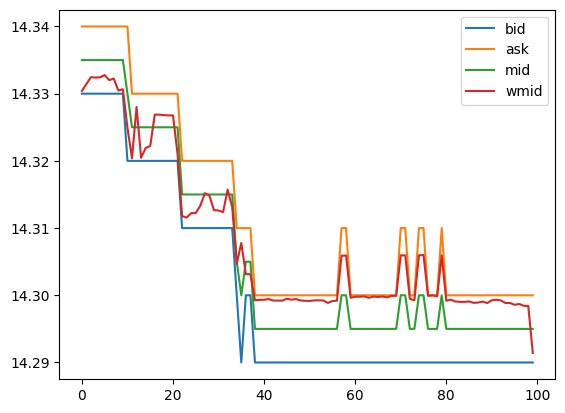

In [5]:
data_1[['bid','ask','mid','wmid']].plot()

<AxesSubplot: >

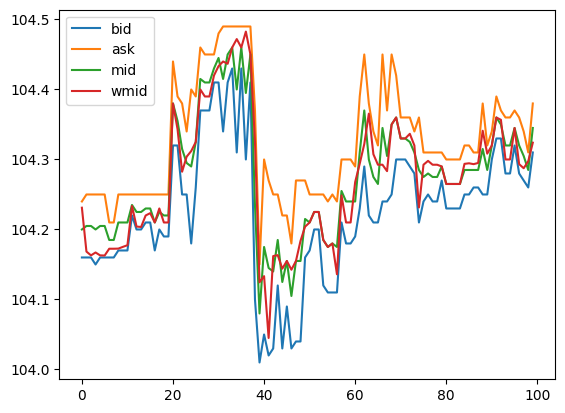

In [6]:
data_2[['bid','ask','mid','wmid']].plot()

# Desirable features of the Micro-Price

논문에서 제시하는 가격


$$ P^{micro}_t = F(M_t, I_t, S_t) = M_t + g(I_t, S_t) $$ 

where $g$ is function of micro-price adjustment

- Martingale
- Computationally fast
- Better short term price predictions than the midprice or weighted midprice


### Define
$$ P^{micro}_t = \lim_{n \to \infty} P^n_t $$


where the approximating sequence of martingale prices is given by
$$ P^n_t = \mathbb{E}[M_{\tau_n}|I_t, S_t] $$

$\tau_1, ... ,\tau_n$ are (random) times when the mid-price $M_t$ changes


The micro-price is the expected mid-price in the distant duture


In practice, the distant future is well captured by $P^6_t$, the expected mid price after 6 price moves.

In [7]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [8]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread = T.ask - T.bid
    ticksize = np.round(min(spread.loc[spread>0])*100)/100
    T.spread = spread

    # adds the spread and mid prices
    T['spread'] = np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid'] = (T['bid']+T['ask'])/2

    # filters out the zero spreads >= n_spread
    T = T.loc[(T['spread'] <= n_spread*ticksize) & (T['spread'] > 0)]
    T['imb'] = T['bs']/(T['bs']+T['as']) # imb = imbalance, bs = buy size, as = ask size

    # discretizes the imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'],n_imb,labels=False)
    T['next_mid'] = T['mid'].shift(-dt)

     #step ahead state variables
    T['next_spread'] = T['spread'].shift(-dt)
    T['next_time'] = T['time'].shift(-dt)
    T['next_imb_bucket'] = T['imb_bucket'].shift(-dt)

    # step ahead change in price
    T['dM'] = np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM >= -ticksize*1.1)]

    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']

    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize

In [9]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb * n_spread)]
    R1=T1[:,(n_imb * n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [10]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1) # 6까지만 계산해도 잘 수렴하기에 6까지만 계산
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.005,0.005)
    plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    return G6

In [13]:
n_imb=10
n_spread=2
dt=1
data=get_df('BAC') 
ticker='BAC'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize=prep_data_sym(data,n_imb,dt,n_spread)

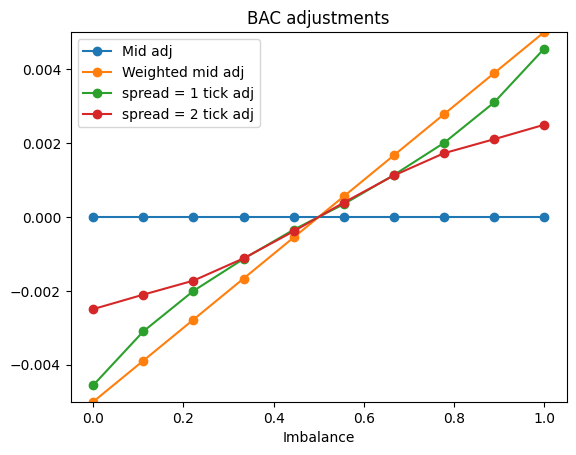

In [15]:
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

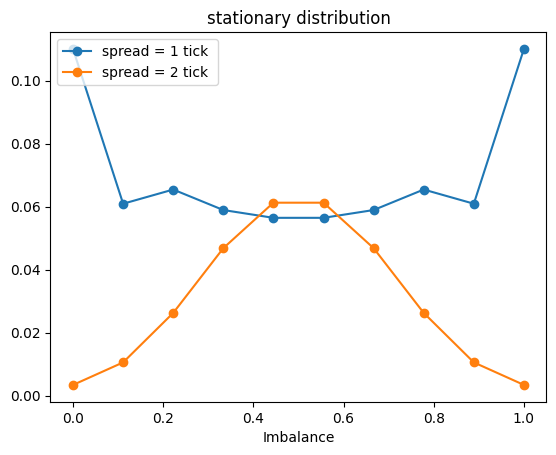

In [16]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')
